In [17]:
import numpy as np
import pandas as pd

In [18]:
Tetrapos_atomic=pd.read_csv("C:\\Users\\HP\\Desktop\\SEM#3\\MLBA\\atomic_pentapos.csv")
Tetraneg_atomic=pd.read_csv("C:\\Users\\HP\\Desktop\\SEM#3\\MLBA\\atomic_pentaneg.csv")
Tetrapos_atomic['Label'] = 1
Tetraneg_atomic['Label'] = 0

In [19]:
Tetra_dataset_atomic=Tetraneg_atomic.append(Tetrapos_atomic, ignore_index = True)

In [20]:
Names=Tetra_dataset_atomic['ID']
Class=Tetra_dataset_atomic['Label']
Tetra_data_atomic=Tetra_dataset_atomic.drop(['ID','Label'],axis=1)

In [21]:
from sklearn.model_selection import train_test_split
def splitdataset(fulldata,fulldatalabel,k):
    X_train, X_test, y_train, y_test = train_test_split(fulldata,fulldatalabel,test_size=k,random_state=100)
    return X_train,X_test,y_train,y_test

In [22]:
X_train,X_test,y_train,y_test=splitdataset(Tetra_data_atomic,Class,0.30) # HOLD OUT SET

In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
param_grid = {
    'bootstrap': [True],
    'max_depth': [5,10,20],
    'max_features': [5],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2)

# Fit the grid search to the data
grid_search.fit(X_train,y_train)
print(grid_search.best_params_)
best_grid = grid_search.best_estimator_



Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   31.7s
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:   49.8s finished
C:\ProgramData\Anaconda2\envs\3point7\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'bootstrap': True, 'max_depth': 5, 'max_features': 5, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}


In [24]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features=5, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
rf.fit(X_train,y_train)
y_pred=rf.predict(X_test)
print(accuracy_score(y_pred,y_test))
print(classification_report(y_pred,y_test))

0.5987654320987654
              precision    recall  f1-score   support

           0       0.52      0.63      0.57        68
           1       0.68      0.57      0.62        94

    accuracy                           0.60       162
   macro avg       0.60      0.60      0.60       162
weighted avg       0.61      0.60      0.60       162



In [25]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
def svc_param_selection(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10]
    gammas = [0.001, 0.01, 0.1, 1]
    kernels=['rbf']
    param_grid = {'C': Cs, 'gamma' : gammas,'kernel':kernels}
    grid_search = GridSearchCV(svm.SVC(), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

In [26]:
svc_param_selection(X_train,y_train,5)

C:\ProgramData\Anaconda2\envs\3point7\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}

In [27]:
from sklearn.model_selection import LeaveOneOut 
def LOOV(traindata,trainlabel,model): 
    X=traindata
    y=trainlabel
    loo = LeaveOneOut()
    loo.get_n_splits(X)
    trainaccuracy=[]
    pred_prob=[]
    predlabel=[]
    truelabel=[]
    for train_index, test_index in loo.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        X_train=pd.DataFrame(X_train)
        X_test=pd.DataFrame(X_test)
        y_train=pd.Series(y_train)
        y_test=pd.Series(y_test)       
        model.fit(X_train,y_train)
        y_pred=model.predict(X_test)
        y_pred_train=model.predict(X_train)
        trainaccuracy.append(accuracy_score(y_train, y_pred_train))
        prob=model.predict_proba(X_test)
        pred_prob.append(prob[0][1])
        predlabel.append(y_pred[0])
        truelabel.append(y_test.iloc[0])
    print("Average Test Accuracy :",accuracy_score(truelabel,predlabel))
    print("Average Train Accuracy :",sum(trainaccuracy)/len(trainaccuracy))
    return truelabel,predlabel,pred_prob
   

In [28]:
X_train=X_train.reset_index(drop=True)
y_train=y_train.reset_index(drop=True)

In [29]:
from sklearn import metrics
import matplotlib.pyplot as plt
model=svm.SVC(C=1, gamma=0.001,kernel='rbf',probability=True)

truelabel,predlabel,pred_prob=LOOV(X_train,y_train,model)
auc = metrics.roc_auc_score(truelabel, pred_prob)
print(auc)


Average Test Accuracy : 0.58994708994709
Average Train Accuracy : 0.6032868791489447
0.633927821485567


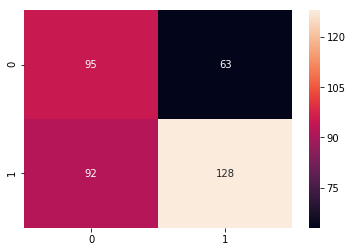

In [30]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cf=confusion_matrix(predlabel,truelabel)
ax = sns.heatmap(cf, annot=True, fmt="d")

# SVM HOLD OUT

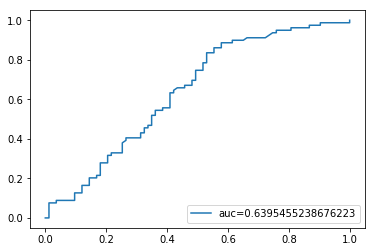

              precision    recall  f1-score   support

           0       0.57      0.64      0.60        74
           1       0.66      0.59      0.62        88

    accuracy                           0.61       162
   macro avg       0.61      0.61      0.61       162
weighted avg       0.62      0.61      0.61       162



In [31]:
model=svm.SVC(C=1, gamma=0.1,kernel='rbf',probability=True)
model.fit(X_train,y_train)
y_pred=model.predict(X_test)
pred_prob=model.predict_proba(X_test)
auc = metrics.roc_auc_score(y_test,pred_prob[:,1])
fpr, tpr, _ = metrics.roc_curve(y_test,pred_prob[:,1])
plt.plot(fpr,tpr,label="auc="+str(auc))
plt.legend(loc=4)
plt.show()
print(classification_report(y_pred,y_test))

# Random Forest Leave One Out

In [32]:
model = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features=5, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
truelabel,predlabel,pred_prob=LOOV(X_train,y_train,model)
print(classification_report(predlabel,truelabel))
auc = metrics.roc_auc_score(truelabel, pred_prob)

Average Test Accuracy : 0.6296296296296297
Average Train Accuracy : 0.7994119545843734
              precision    recall  f1-score   support

           0       0.56      0.64      0.60       163
           1       0.70      0.62      0.66       215

    accuracy                           0.63       378
   macro avg       0.63      0.63      0.63       378
weighted avg       0.64      0.63      0.63       378



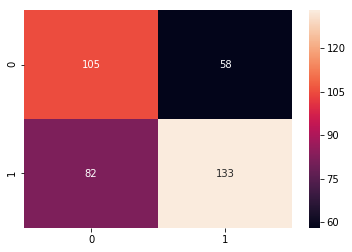

In [33]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cf=confusion_matrix(predlabel,truelabel)
ax = sns.heatmap(cf, annot=True, fmt="d")

# random Forest holdout

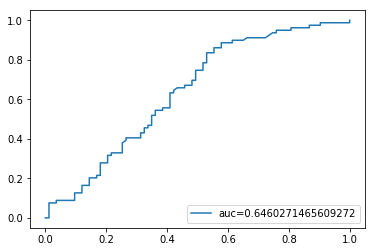

              precision    recall  f1-score   support

           0       0.49      0.65      0.56        63
           1       0.72      0.58      0.64        99

    accuracy                           0.60       162
   macro avg       0.61      0.61      0.60       162
weighted avg       0.63      0.60      0.61       162



In [34]:
model = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features=5, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
model.fit(X_train,y_train)
y_pred=model.predict(X_test)
pred_prob=model.predict_proba(X_test)
auc = metrics.roc_auc_score(y_test,pred_prob[:,1])
plt.plot(fpr,tpr,label="auc="+str(auc))
plt.legend(loc=4)
plt.show()
print(classification_report(y_pred,y_test))

In [43]:
# Logistic Regression LOOV

C:\ProgramData\Anaconda2\envs\3point7\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda2\envs\3point7\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda2\envs\3point7\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda2\envs\3point7\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda2\envs\3point7\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, i

Average Test Accuracy : 0.6005291005291006
Average Train Accuracy : 0.6096866096866072


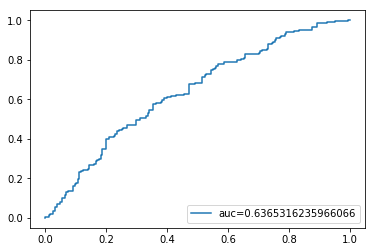

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import matplotlib.pyplot as plt
model=LogisticRegression(random_state=10, solver='liblinear',penalty='l1',max_iter=100)
truelabel,predlabel,pred_prob=LOOV(X_train,y_train,model)
fpr, tpr, _ = metrics.roc_curve(truelabel,pred_prob)
auc = metrics.roc_auc_score(truelabel, pred_prob)
plt.plot(fpr,tpr,label="auc="+str(auc))
plt.legend(loc=4)
plt.show()

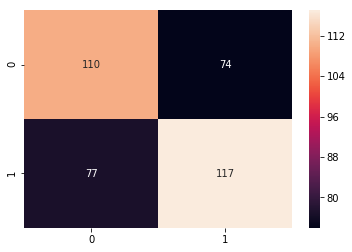

In [36]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cf=confusion_matrix(predlabel,truelabel)
ax = sns.heatmap(cf, annot=True, fmt="d")

In [37]:
print(classification_report(predlabel,truelabel))


              precision    recall  f1-score   support

           0       0.59      0.60      0.59       184
           1       0.61      0.60      0.61       194

    accuracy                           0.60       378
   macro avg       0.60      0.60      0.60       378
weighted avg       0.60      0.60      0.60       378



# LOGISTIC Regression on HOLD OUT SET

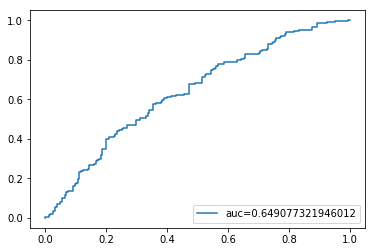

              precision    recall  f1-score   support

           0       0.59      0.64      0.62        76
           1       0.66      0.60      0.63        86

    accuracy                           0.62       162
   macro avg       0.62      0.62      0.62       162
weighted avg       0.63      0.62      0.62       162



In [38]:
model=LogisticRegression(random_state=10, solver='liblinear',penalty='l1',max_iter=100)
model.fit(X_train,y_train)
y_pred=model.predict(X_test)
pred_prob=model.predict_proba(X_test)
auc = metrics.roc_auc_score(y_test,pred_prob[:,1])
plt.plot(fpr,tpr,label="auc="+str(auc))
plt.legend(loc=4)
plt.show()
print(classification_report(y_pred,y_test))

# KNeighborsClassifier

Average Test Accuracy : 0.6164021164021164
Average Train Accuracy : 0.7475615061821953


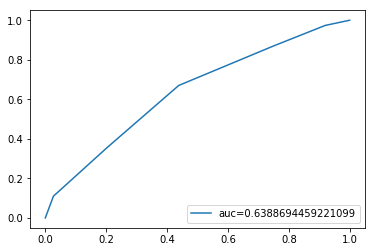

In [39]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=5)
truelabel,predlabel,pred_prob=LOOV(X_train,y_train,model)
fpr, tpr, _ = metrics.roc_curve(truelabel,pred_prob)
auc = metrics.roc_auc_score(truelabel, pred_prob)
plt.plot(fpr,tpr,label="auc="+str(auc))
plt.legend(loc=4)
plt.show()

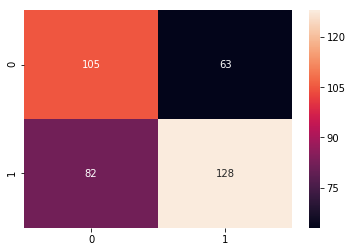

In [40]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cf=confusion_matrix(predlabel,truelabel)
ax = sns.heatmap(cf, annot=True, fmt="d")

In [41]:
print(classification_report(predlabel,truelabel))

              precision    recall  f1-score   support

           0       0.56      0.62      0.59       168
           1       0.67      0.61      0.64       210

    accuracy                           0.62       378
   macro avg       0.62      0.62      0.61       378
weighted avg       0.62      0.62      0.62       378



# KNN on Holdout set

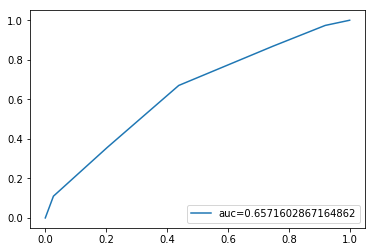

              precision    recall  f1-score   support

           0       0.60      0.65      0.63        77
           1       0.66      0.61      0.63        85

    accuracy                           0.63       162
   macro avg       0.63      0.63      0.63       162
weighted avg       0.63      0.63      0.63       162



In [42]:
model=KNeighborsClassifier(n_neighbors=5)
model.fit(X_train,y_train)
y_pred=model.predict(X_test)
pred_prob=model.predict_proba(X_test)
auc = metrics.roc_auc_score(y_test,pred_prob[:,1])
plt.plot(fpr,tpr,label="auc="+str(auc))
plt.legend(loc=4)
plt.show()
print(classification_report(y_pred,y_test))